Test whether experiments A and B are consistent with theory

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")

import sys
sys.path.insert(1, '../src/')
from lib import *
import params as pm

In [2]:
exp_names = np.array(['A', 'B'])
experiments = {}

#dict to store values
for name in exp_names:
    experiments[name] = {}

#load cls from memory

for key in experiments:
    experiments[key]['cls_obs'] = np.load("../dat/pCls/1000mocks/pCls_" + key + ".npy")
    experiments[key]['CLs_obs'] = np.zeros((pm.NMOCKS, pm.ELL.shape[0] - 1))
    experiments[key]['pCLs_obs'] = np.zeros((pm.NMOCKS, pm.ELL.shape[0] - 1))
    
   #read in fsky and nl
    experiments[key]['nl'] = np.load("../dat/pCls/1000mocks/noise_window_" +key +".npy")
    experiments[key]['fsky'] = np.load("../dat/pCls/1000mocks/fsky_" +key +".npy")
    
#calculate pCls
for key in ['A', 'B']:
    #experiments[key]['pcls_obs'] = (experiments[key]['cls_obs'] * experiments[key]['fsky'][:,np.newaxis]) + \
    #experiments[key]['nl'][:,np.newaxis]
    experiments[key]['pcls_obs'] = (experiments[key]['cls_obs'] * experiments[key]['fsky'][:,np.newaxis])
    
#bin power spectrum
for key in experiments:
    for i in range(pm.NMOCKS):
        ELL_mid, experiments[key]['CLs_obs'][i] = bin_mat(pm.ell[:pm.NSIDE], 
                                                           experiments[key]['cls_obs'][i][:pm.NSIDE],
                                                           pm.ELL) #Cls up to NSIDE is good 
        ELL_mid, experiments[key]['pCLs_obs'][i] = bin_mat(pm.ell[:pm.NSIDE], 
                                                           experiments[key]['pcls_obs'][i][:pm.NSIDE],
                                                           pm.ELL) #Cls up to NSIDE is good 

../src/lib.py:171: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mat_t=mat_r_dr[slc]


In [5]:
pcl_B = np.load("../dat/pCls/th/pcl_th.npy")
cls_elg_th = np.load("../dat/cosmology_ini/gaussian_mocks/cl_th.npy")

In [8]:
invcls_th = np.linalg.inv(cls_elg_th)

LinAlgError: 1-dimensional array given. Array must be at least two-dimensional

In [4]:
pcl_B.shape

(1000, 2048)

# Test simple MCMC inference

In [89]:
import zeus
import matplotlib.pyplot as plt
import emcee
import numpy as np
plt.style.use("ggplot")

In [90]:
# define the model function
def straight_line(x, m, c):
    ''' A straight line model: y = m*x + c '''
    return m*x + c

# set the true values of the model parameters for creating the data
m_true = 3.5 # gradient of the line
c_true = 1.2 # y-intercept of the line

# Set the x-coordinates of the data points
M = 70 # Number of data points
x = np.sort(10.0 * np.random.rand(M)) # their x-coordinates

In [107]:
# create the data - the model plus Gaussian noise
sigma = 3.0 # standard deviation of the noise
data = straight_line(x, m_true, c_true) + sigma * np.random.randn(M)

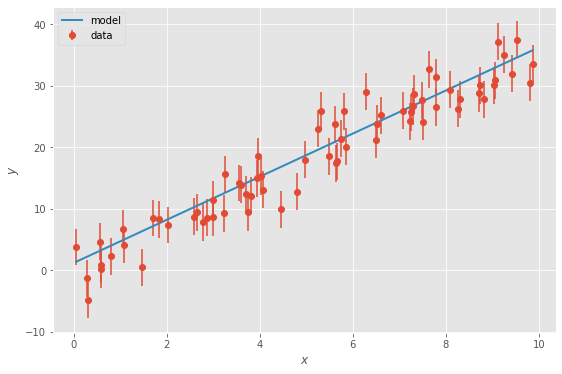

In [108]:
plt.figure(figsize=(9,6))
plt.errorbar(x, data, yerr=sigma, fmt="o", label='data')
plt.plot(x, straight_line(x, m_true, c_true), '-', lw=2, label='model')
plt.legend()
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.show()

In [109]:
def loglike(theta, data, sigma, x):
    '''The natural logarithm of the likelihood.'''

    # unpack the model parameters
    m, c = theta

    # evaluate the model
    md = straight_line(x, m, c)

    # return the log likelihood
    return -0.5 * np.sum(((md - data)/sigma)**2)

In [ ]:
ndim = 2 # Number of parameters/dimensions (e.g. m and c)
nwalkers = 10 # Number of walkers to use. It should be at least twice the number of dimensions.
nsteps = 5000 # Number of steps/iterations.

start = np.array([m_true, c_true]) + np.random.randn(nwalkers, ndim) # Initial positions of the walkers.

sampler = zeus.EnsembleSampler(nwalkers, ndim, loglike, args=[data, sigma, x]) # Initialise the sampler
sampler.run_mcmc(start, nsteps) # Run sampling
sampler.summary # Print summary diagnostics

Initialising ensemble of 10 walkers...
Sampling progress :  61%|██████    | 3046/5000 [00:10<00:07, 275.50it/s]

In [ ]:
# flatten the chains, thin them by a factor of 10, and remove the burn-in (first half of the chain)
chain = sampler.get_chain(flat=True, discard=nsteps//2, thin=10)

# plot marginal posterior distributions
#fig, axes = zeus.cornerplot(chain, labels=['m', 'c'], truth=[m_true, c_true]);
import corner
figure = corner.corner(chain, labels=[r"$m$", r"$c$"],
                       quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 12}, truths=[m_true, c_true])

In [ ]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, loglike, args=(data, sigma, x))
sampler.run_mcmc(start, 5000, progress=True);

In [ ]:
sampler.get_autocorr_time()

In [ ]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)

In [ ]:
figure = corner.corner(flat_samples, labels=[r"$m$", r"$c$"],
                       quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 12}, truths=[m_true, c_true])

## Consider with prior

In [ ]:
def logprior(theta):
    ''' The natural logarithm of the prior probability. '''

    lp = 0.

    # unpack the model parameters from the tuple
    m, c = theta

    # uniform prior on c
    cmin = -10. # lower range of prior
    cmax = 10.  # upper range of prior

    # set prior to 1 (log prior to 0) if in the range and zero (-inf) outside the range
    lp = 0. if cmin < c < cmax else -np.inf

    # Gaussian prior on m
    mmu = 3.     # mean of the Gaussian prior
    msigma = 10. # standard deviation of the Gaussian prior
    lp -= 0.5*((m - mmu)/msigma)**2

    return lp

In [ ]:
def logpost(theta, data, sigma, x):
    '''The natural logarithm of the posterior.'''

    return logprior(theta) + loglike(theta, data, sigma, x)

In [ ]:
sampler = zeus.EnsembleSampler(nwalkers, ndim, logpost, args=[data, sigma, x]) # Initialise the sampler
sampler.run_mcmc(start, nsteps) # Run sampling
sampler.summary # Print summary diagnostics

In [ ]:
# flatten the chains, thin them by a factor of 10, and remove the burn-in (first half of the chain)
chain_bayes = sampler.get_chain(flat=True, discard=nsteps//2, thin=10)

# plot marginal posterior distributions
#fig, axes = zeus.cornerplot(chain, labels=['m', 'c'], truth=[m_true, c_true]);
import corner
figure = corner.corner(chain_bayes, labels=[r"$m$", r"$c$"],
                       quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 12}, truths=[m_true, c_true])

In [ ]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, logpost, args=(data, sigma, x))
sampler.run_mcmc(start, 5000, progress=True);

In [ ]:
flat_samples_bayes = sampler.get_chain(discard=100, thin=15, flat=True)

In [ ]:
figure = corner.corner(flat_samples_bayes, labels=[r"$m$", r"$c$"],
                       quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 12}, truths=[m_true, c_true])

Test with cosmology

In [60]:
import sys
sys.path.insert(1, '/home/tkarim/imaging-sys-covariance/src/')
from lib import *
import params as pm

In [62]:
b1 = 1.75
Omega_c = 0.3
sigma8 = 0.8

In [86]:
theory_true = cgll(ell = pm.ell, bias = b1, Omega_c = Omega_c, 
         Omega_b = 0.0486, h = 0.6774, sigma8 = sigma8, n_s = 0.965, 
                   transfer_function = 'eisenstein_hu')
_, theory_true_binned = bin_mat(pm.ell, theory_true, pm.ELL)
cov_binned = np.cov(theory_true_binned)

/home/tkarim/imaging-sys-covariance/src/lib.py:171: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mat_t=mat_r_dr[slc]


In [88]:
cov_binned

array(1.04997132e-12)

In [68]:
def loglike(theta, data_binned, cov_binned):
    """
    Returns log likelihood 
    
    Arguments:
        theta (list) : list of parameters to be inferred; b1, Omega_c and A_s
        data_binned (array) : observed pCls binned
        cov_binned (matrix) : covariance matrix
    """
    
    theory = cgll(ell = pm.ell, bias = theta[0], Omega_c = theta[1], 
         Omega_b = 0.0486, h = 0.6774, sigma8 = theta[2], n_s = 0.965, transfer_function = 'eisenstein_hu')
    _, theory_binned = bin_mat(pm.ell, theory, pm.ELL)
    
    diff = theory_binned - data_binned
    
    invCov_binned = np.linalg.inv(cov_binned)
    
    return -0.5 * (diff).T @ invCov_binned @ diff

In [69]:
def cov_diag(ell, cl):
    return 2*cl**2/((2+ell + 1))

In [77]:
a = np.zeros((pm.ell.shape[0], pm.ell.shape[0]))
np.fill_diagonal(a, cov_diag(pm.ell, theory))

In [79]:
np.diag(a)

array([1.13314660e-14, 6.91436543e-14, 1.42820034e-13, ...,
       1.71297340e-17, 1.70670548e-17, 1.70046792e-17])

In [81]:
cov_diag(pm.ell, theory)

array([1.13314660e-14, 6.91436543e-14, 1.42820034e-13, ...,
       1.71297340e-17, 1.70670548e-17, 1.70046792e-17])